In [1]:
# Trains the structure-sequence hybrid predictor as well as the final CNN from Valeri et al. for comparison


# 7/1/22

import sys
sys.path.insert(1,"../src")
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras
import matplotlib.pyplot as plt
import util
import GA_util
import keras.layers
print('loaded tf',tf.__version__)
from sklearn.model_selection import train_test_split



tfk = tensorflow.keras
tfkl = tfk.layers

loaded tf 2.11.0


(55390, 4, 59)


(array([ 5036.,  5026.,  5045.,  5035.,  5035.,  5036.,  5035.,  3530.,
         6541., 10071.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

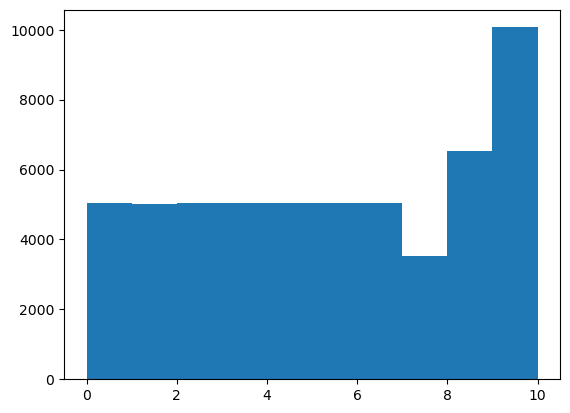

In [7]:
#Initial Data Loading for Toehold Switch Regression Analysis

from util import one_hot_encode,load_valeri_data



valeri_sequences,on,off = load_valeri_data(path='../data/toehold_data/Toehold_Dataset_Final_2019-10-23.csv',threshold=-1)
print(valeri_sequences.shape)

on = on.values
off = off.values

# valeri_ppms = GA_util.create_ppms_fast(valeri_sequences)


from sklearn.preprocessing import KBinsDiscretizer

est =  KBinsDiscretizer(n_bins=11,encode='ordinal',strategy='quantile')
bins = est.fit(on.reshape(-1,1))
encoded_vals = bins.transform(on.reshape(-1,1))

plt.figure()
plt.hist(encoded_vals)

In [8]:
from datetime import date

today = date.today()

# joint_model.save('models/predictor_%s'%today)

In [56]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

#Cross Validation 

fold = 3


joint_mse_save = []
joint_on_r2_save = []
joint_off_r2_save = []
joint_on_spearman_save = []
joint_off_spearman_save = []

valeri_mse_save = []
valeri_on_r2_save = []
valeri_off_r2_save = []
valeri_on_spearman_save = []
valeri_off_spearman_save = []


optimizer = keras.optimizers.Adam(learning_rate=0.0001)

for i in range(fold):
    #Have to reset weights
    joint_model = GA_util.create_SANDSTORM(latent_dim=64,output_nodes=2)
    valeri_model = GA_util.create_valeri_model()
    
    #Split w.r.t. ON value distribution, as off is uniform
    switch_train,switch_test,on_train,on_test,off_train,off_test= train_test_split(valeri_sequences,on,off,test_size=0.20,stratify=encoded_vals) 
   
    #Valeri model takes the transpose of the sequences as inputs relative to our model
    valeri_switch_train = tf.transpose(switch_train,(0,2,1))
    valeri_switch_test = tf.transpose(switch_test,(0,2,1))

    #Joint model takes inputs with one more nucleotide in the 5' direction (C) for a total length of 60
    #This step adds the C to our sequences while respecting the same train/test split
    c = np.array([[0.0],[0.0],[1.0],[0.0]])
    c_train_stack = np.stack((c,) * switch_train.shape[0], axis=0)
    c_test_stack = np.stack((c,) * switch_test.shape[0],axis=0)
    switch_train = np.concatenate((c_train_stack,switch_train),axis=2)
    switch_test = np.concatenate((c_test_stack,switch_test),axis = 2)
    ppm_train = GA_util.prototype_ppms_fast(switch_train)
    ppm_test = GA_util.prototype_ppms_fast(switch_test)
    


    

    #Fit the joint model and save metrics
    joint_model.compile(optimizer=optimizer,loss='mse')
    epochs=20
    hist = joint_model.fit(
        [switch_train,ppm_train],[on_train,off_train],batch_size=64,validation_data=[[switch_test,ppm_test],[on_test,off_test]],epochs=epochs)

    # joint_model.save('tmp_models/sandstorm_len_%i'%sizes[i])
    mse = hist.history['val_loss'][-1]
    joint_mse_save.append(mse)
    
    on_predictions = joint_model.predict([switch_test,ppm_test])[0]
    off_predictions = joint_model.predict([switch_test,ppm_test])[1]

    on_r2 = r2_score(on_test,on_predictions)
    off_r2 = r2_score(off_test,off_predictions)
    
    joint_on_r2_save.append(on_r2)
    joint_off_r2_save.append(off_r2)

    on_spearman = spearmanr(on_test,on_predictions)
    off_spearman = spearmanr(off_test,off_predictions)

    joint_on_spearman_save.append(on_spearman)
    joint_off_spearman_save.append(off_spearman)
    
    
    
    #####Running Valeri et al. Model
    valeri_model.compile(optimizer=optimizer,loss='mse')
    epochs=20
    valeri_hist = valeri_model.fit(valeri_switch_train,
                                   [on_train,off_train],
                                   batch_size=128,
                                   validation_data=[valeri_switch_test,[on_test,off_test]],
                                   epochs=epochs)
    
    valeri_mse = valeri_hist.history['val_loss'][-1]
    valeri_mse_save.append(valeri_mse)
    
    valeri_on_predictions = valeri_model(valeri_switch_test)[0]
    valeri_off_predictions = valeri_model(valeri_switch_test)[1]

    valeri_on_r2 = r2_score(on_test,valeri_on_predictions)
    valeri_off_r2 = r2_score(off_test,valeri_off_predictions)
    
    valeri_on_r2_save.append(valeri_on_r2)
    valeri_off_r2_save.append(valeri_off_r2)

    valeri_on_spearman = spearmanr(on_test,valeri_on_predictions) 
    valeri_off_spearman = spearmanr(off_test,valeri_off_predictions)
    
    valeri_on_spearman_save.append(valeri_on_spearman)
    valeri_off_spearman_save.append(valeri_off_spearman)
    


Epoch 1/20


2025-03-18 22:01:55.962599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


693/693 [==============================] - ETA: 0s - loss: 0.2945 - prediction_output_0_loss: 0.1652 - prediction_output_1_loss: 0.1293

2025-03-18 22:02:03.608061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


693/693 [==============================] - 9s 12ms/step - loss: 0.2945 - prediction_output_0_loss: 0.1652 - prediction_output_1_loss: 0.1293 - val_loss: 0.2468 - val_prediction_output_0_loss: 0.1275 - val_prediction_output_1_loss: 0.1193
Epoch 2/20
693/693 [==============================] - 7s 11ms/step - loss: 0.2164 - prediction_output_0_loss: 0.1071 - prediction_output_1_loss: 0.1094 - val_loss: 0.1890 - val_prediction_output_0_loss: 0.0922 - val_prediction_output_1_loss: 0.0968
Epoch 3/20
693/693 [==============================] - 8s 11ms/step - loss: 0.1707 - prediction_output_0_loss: 0.0835 - prediction_output_1_loss: 0.0872 - val_loss: 0.1545 - val_prediction_output_0_loss: 0.0778 - val_prediction_output_1_loss: 0.0767
Epoch 4/20
693/693 [==============================] - 7s 11ms/step - loss: 0.1428 - prediction_output_0_loss: 0.0705 - prediction_output_1_loss: 0.0723 - val_loss: 0.1328 - val_prediction_output_0_loss: 0.0671 - val_prediction_output_1_loss: 0.0657
Epoch 5/20
693/

2025-03-18 22:04:29.073924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


347/347 [==============================] - 1s 3ms/step
Epoch 1/20


2025-03-18 22:04:31.855964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


347/347 [==============================] - ETA: 0s - loss: 0.1246 - on_output_loss: 0.0795 - off_output_loss: 0.0451

2025-03-18 22:04:35.136925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


347/347 [==============================] - 4s 10ms/step - loss: 0.1246 - on_output_loss: 0.0795 - off_output_loss: 0.0451 - val_loss: 0.1041 - val_on_output_loss: 0.0675 - val_off_output_loss: 0.0365
Epoch 2/20
347/347 [==============================] - 3s 9ms/step - loss: 0.1039 - on_output_loss: 0.0665 - off_output_loss: 0.0374 - val_loss: 0.1016 - val_on_output_loss: 0.0658 - val_off_output_loss: 0.0358
Epoch 3/20
347/347 [==============================] - 3s 9ms/step - loss: 0.1002 - on_output_loss: 0.0640 - off_output_loss: 0.0362 - val_loss: 0.0968 - val_on_output_loss: 0.0622 - val_off_output_loss: 0.0346
Epoch 4/20
347/347 [==============================] - 3s 9ms/step - loss: 0.0975 - on_output_loss: 0.0622 - off_output_loss: 0.0353 - val_loss: 0.0950 - val_on_output_loss: 0.0611 - val_off_output_loss: 0.0339
Epoch 5/20
347/347 [==============================] - 3s 9ms/step - loss: 0.0954 - on_output_loss: 0.0608 - off_output_loss: 0.0345 - val_loss: 0.0924 - val_on_output_los

2025-03-18 22:05:41.029233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


693/693 [==============================] - ETA: 0s - loss: 0.1087 - prediction_output_0_loss: 0.0697 - prediction_output_1_loss: 0.0390

2025-03-18 22:05:48.833016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


693/693 [==============================] - 9s 12ms/step - loss: 0.1087 - prediction_output_0_loss: 0.0697 - prediction_output_1_loss: 0.0390 - val_loss: 0.0960 - val_prediction_output_0_loss: 0.0610 - val_prediction_output_1_loss: 0.0350
Epoch 2/20
693/693 [==============================] - 8s 11ms/step - loss: 0.0930 - prediction_output_0_loss: 0.0587 - prediction_output_1_loss: 0.0343 - val_loss: 0.0913 - val_prediction_output_0_loss: 0.0573 - val_prediction_output_1_loss: 0.0340
Epoch 3/20
693/693 [==============================] - 7s 11ms/step - loss: 0.0888 - prediction_output_0_loss: 0.0557 - prediction_output_1_loss: 0.0331 - val_loss: 0.0883 - val_prediction_output_0_loss: 0.0550 - val_prediction_output_1_loss: 0.0333
Epoch 4/20
693/693 [==============================] - 7s 11ms/step - loss: 0.0855 - prediction_output_0_loss: 0.0533 - prediction_output_1_loss: 0.0322 - val_loss: 0.0858 - val_prediction_output_0_loss: 0.0532 - val_prediction_output_1_loss: 0.0326
Epoch 5/20
693/

2025-03-18 22:08:10.827033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


347/347 [==============================] - 1s 3ms/step
Epoch 1/20


2025-03-18 22:08:13.261169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


347/347 [==============================] - ETA: 0s - loss: 0.1199 - on_output_loss: 0.0774 - off_output_loss: 0.0424

2025-03-18 22:08:16.534239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


347/347 [==============================] - 4s 10ms/step - loss: 0.1199 - on_output_loss: 0.0774 - off_output_loss: 0.0424 - val_loss: 0.0982 - val_on_output_loss: 0.0632 - val_off_output_loss: 0.0350
Epoch 2/20
347/347 [==============================] - 3s 9ms/step - loss: 0.0999 - on_output_loss: 0.0640 - off_output_loss: 0.0359 - val_loss: 0.0939 - val_on_output_loss: 0.0601 - val_off_output_loss: 0.0337
Epoch 3/20
347/347 [==============================] - 3s 9ms/step - loss: 0.0964 - on_output_loss: 0.0617 - off_output_loss: 0.0347 - val_loss: 0.0908 - val_on_output_loss: 0.0579 - val_off_output_loss: 0.0329
Epoch 4/20
347/347 [==============================] - 3s 9ms/step - loss: 0.0933 - on_output_loss: 0.0597 - off_output_loss: 0.0336 - val_loss: 0.0894 - val_on_output_loss: 0.0571 - val_off_output_loss: 0.0323
Epoch 5/20
347/347 [==============================] - 3s 9ms/step - loss: 0.0907 - on_output_loss: 0.0579 - off_output_loss: 0.0328 - val_loss: 0.0863 - val_on_output_los

2025-03-18 22:09:19.572347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


693/693 [==============================] - ETA: 0s - loss: 0.2668 - prediction_output_0_loss: 0.1888 - prediction_output_1_loss: 0.0780

2025-03-18 22:09:27.152693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


693/693 [==============================] - 9s 12ms/step - loss: 0.2668 - prediction_output_0_loss: 0.1888 - prediction_output_1_loss: 0.0780 - val_loss: 0.1976 - val_prediction_output_0_loss: 0.1186 - val_prediction_output_1_loss: 0.0790
Epoch 2/20
693/693 [==============================] - 7s 11ms/step - loss: 0.1724 - prediction_output_0_loss: 0.0961 - prediction_output_1_loss: 0.0763 - val_loss: 0.1533 - val_prediction_output_0_loss: 0.0821 - val_prediction_output_1_loss: 0.0712
Epoch 3/20
693/693 [==============================] - 7s 11ms/step - loss: 0.1439 - prediction_output_0_loss: 0.0769 - prediction_output_1_loss: 0.0670 - val_loss: 0.1360 - val_prediction_output_0_loss: 0.0735 - val_prediction_output_1_loss: 0.0625
Epoch 4/20
693/693 [==============================] - 7s 10ms/step - loss: 0.1243 - prediction_output_0_loss: 0.0667 - prediction_output_1_loss: 0.0576 - val_loss: 0.1147 - val_prediction_output_0_loss: 0.0644 - val_prediction_output_1_loss: 0.0503
Epoch 5/20
693/

2025-03-18 22:11:46.593669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


347/347 [==============================] - 1s 3ms/step
Epoch 1/20


2025-03-18 22:11:49.013184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


347/347 [==============================] - ETA: 0s - loss: 0.1401 - on_output_loss: 0.0937 - off_output_loss: 0.0464

2025-03-18 22:11:52.292293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


347/347 [==============================] - 4s 10ms/step - loss: 0.1401 - on_output_loss: 0.0937 - off_output_loss: 0.0464 - val_loss: 0.1014 - val_on_output_loss: 0.0659 - val_off_output_loss: 0.0355
Epoch 2/20
347/347 [==============================] - 3s 9ms/step - loss: 0.1059 - on_output_loss: 0.0683 - off_output_loss: 0.0376 - val_loss: 0.0983 - val_on_output_loss: 0.0637 - val_off_output_loss: 0.0346
Epoch 3/20
347/347 [==============================] - 3s 9ms/step - loss: 0.1018 - on_output_loss: 0.0655 - off_output_loss: 0.0363 - val_loss: 0.0953 - val_on_output_loss: 0.0616 - val_off_output_loss: 0.0337
Epoch 4/20
347/347 [==============================] - 3s 9ms/step - loss: 0.0997 - on_output_loss: 0.0643 - off_output_loss: 0.0354 - val_loss: 0.0965 - val_on_output_loss: 0.0631 - val_off_output_loss: 0.0335
Epoch 5/20
347/347 [==============================] - 3s 9ms/step - loss: 0.0980 - on_output_loss: 0.0631 - off_output_loss: 0.0349 - val_loss: 0.0938 - val_on_output_los

In [57]:
our_params = np.sum([np.prod(v.get_shape()) for v in joint_model.trainable_weights])
print(our_params)


valeri_params = np.sum([np.prod(v.get_shape()) for v in valeri_model.trainable_weights])
print(valeri_params)

15118
54772


In [58]:
joint_on_spearman_save = [i[0] for i in joint_on_spearman_save]
joint_off_spearman_save = [i[0] for i in joint_off_spearman_save]

valeri_on_spearman_save = [i[0] for i in valeri_on_spearman_save]
valeri_off_spearman_save = [i[0] for i in valeri_off_spearman_save]

In [59]:
# # mse, r2_on, r2_off, spearman_on, spearman_off, parameters
joint_model_bars = [np.mean(joint_mse_save),
                    np.mean(joint_on_r2_save),
                    np.mean(joint_off_r2_save),
                    np.mean(joint_on_spearman_save),
                    np.mean(joint_off_spearman_save),
                    our_params/valeri_params]


joint_model_variances = [np.std(joint_mse_save),
                         np.std(joint_on_r2_save),
                         np.std(joint_off_r2_save),
                         np.std(joint_on_spearman_save),
                         np.std(joint_off_spearman_save),
                        0]

valeri_model_bars = [np.mean(valeri_mse_save),
                    np.mean(valeri_on_r2_save),
                    np.mean(valeri_off_r2_save),
                    np.mean(valeri_on_spearman_save),
                    np.mean(valeri_off_spearman_save),
                    valeri_params/valeri_params]

valeri_model_variances = [np.std(valeri_mse_save),
                         np.std(valeri_on_r2_save),
                         np.std(valeri_off_r2_save),
                         np.std(valeri_on_spearman_save),
                         np.std(valeri_off_spearman_save),
                         0]

In [62]:
import scipy
joint_model_bars
joint_model_variances

save = []
for i in range(len(joint_model_bars)-1):
    save.append(scipy.stats.ttest_ind_from_stats(joint_model_bars[i], 
                                     joint_model_variances[i], 
                                     3,
                                     valeri_model_bars[i],
                                     valeri_model_variances[i],
                                     3, equal_var=True, alternative='two-sided'))

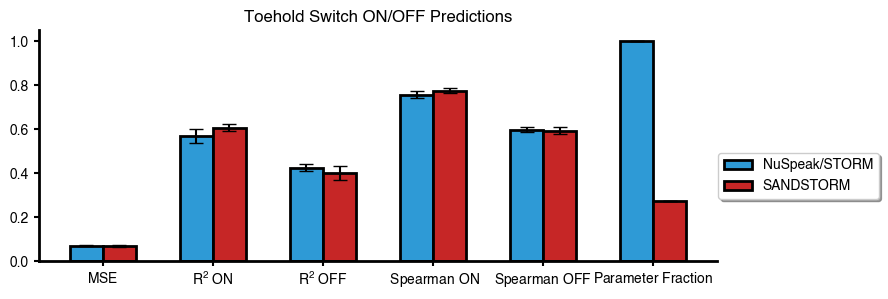

In [64]:
RED = '#C62626'
BLUE = '#2E9AD6'


barwidth = 0.3
#Changing math font and standard font
plt.rcParams.update({'font.size': 10,'font.family':'Helvetica'})
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Helvetica'
plt.rcParams['mathtext.it'] = 'Helvetica:italic'
plt.rcParams['mathtext.bf'] = 'Helvetica:bold'

r1 = np.arange(len(joint_model_bars))
r2 = [x + barwidth for x in r1]

plt.figure(figsize=(8.75,3))

plt.title('Toehold Switch ON/OFF Predictions')
plt.bar(x=r1, height=valeri_model_bars, width = barwidth,yerr=valeri_model_variances, color = BLUE,alpha=1, capsize=5, label='NuSpeak/STORM',edgecolor='black',linewidth=2)
plt.bar(x=r2, height=joint_model_bars, width = barwidth,yerr=joint_model_variances, color = RED,alpha=1,  capsize=5, label='SANDSTORM',edgecolor='black',linewidth=2)




plt.xticks([r + (barwidth/2) for r in range(len(joint_model_bars))], [r'MSE$^{\rm }$', r'R$^{\rm 2}$ ON', r'R$^{\rm 2}$ OFF',r' Spearman$^{\rm }$ ON',r'Spearman$^{\rm }$ OFF',r'Parameter Fraction$^{\rm }$'])
plt.subplot().spines['right'].set_visible(False)
plt.subplot().spines['top'].set_visible(False)
plt.subplot().spines['left'].set_linewidth(2.0)
plt.subplot().spines['bottom'].set_linewidth(2.0)

plt.subplot().xaxis.set_tick_params(width=1.5)
plt.subplot().yaxis.set_tick_params(width=1.5)
plt.legend(loc='upper center', bbox_to_anchor=(1.12, 0.5),
          fancybox=True, shadow=True, ncol=1)
# plt.savefig('../figures/Toehold Predictor',dpi=500,bbox_inches='tight',pad_inches=0.5)
# plt.savefig('../figures/Toehold Predictor.svg',transparent=True,bbox_inches='tight',pad_inches=0.5)







In [32]:
# joint_model.save('../models/predictor_12_3')

INFO:tensorflow:Assets written to: ../models/predictor_12_3/assets


INFO:tensorflow:Assets written to: ../models/predictor_12_3/assets


In [29]:
np.save('stat_tests/joint_model_metrics_12_3.npy',joint_model_bars)
np.save('stat_tests/joint_model_variances_12_3.npy',joint_model_variances)

# joint_model_bars = np.load('stat_tests/joint_model_metrics.npy')
# joint_model_variances = np.load('stat_tests/joint_model_variances.npy')

np.save('stat_tests/valeri_model_metrics_12_3.npy',valeri_model_bars)
np.save('stat_tests/valeri_model_variances_12_3.npy',valeri_model_variances)

# valeri_model_bars = np.load('stat_tests/valeri_model_metrics.npy')
# valeri_model_variances = np.load('stat_tests/valeri_model_variances.npy')